In [1]:
%matplotlib inline

First we’ll need some libraries…

In [2]:
import numpy as np              # for array manipulation
import matplotlib.pyplot as pl  # for plotting stuff
from mayavi import mlab         # optional
from scipy import stats         # optional

********************************************************************************
         to build the TVTK classes (7.0). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



This notebook is accompanied by a file called "A795_sdss.dat", which contains data extracted from the SDSS database (http://skyserver.sdss.org/dr13/en/tools/search/sql.aspx) using SQL.

To read the data we extracted from the SDSS database, something along these lines is probably ok:

In [3]:
def read_sdss(filename):

    datafile = open(filename,'r')
    
    srcid=[];ra=[];dec=[];z=[];zerr=[]
    src=0
    while True:
        line=datafile.readline()
        if not line: break
            
        # remove header info:
        if line[0]!='#':
            items=line.split()
            
            # ignore objects with no redshift info:
            if items[3]!='-9999':
                src+=1
                srcid.append(float(src))
                ra.append(float(items[0]))
                dec.append(float(items[1]))
                z.append(float(items[2]))
                zerr.append(float(items[3]))
            
    srcid=np.array(srcid)
    ra=np.array(ra)
    dec=np.array(dec)
    z=np.array(z)
    zerr=np.array(zerr)
    
    sdss_data = np.vstack((srcid,ra,dec,z))
            
    return sdss_data

To run this on our output data file:

In [4]:
sdss_data = read_sdss("A795_sdss.dat")
print "Number of objects: ",sdss_data.shape[1]

Number of objects:  1913


There are a bunch of different ways that you could view these data in Python. Here I’ve chosen to play with the mayavi library.

**Note:** this plot will appear in a separate window, even though the matplotlib plots appear in-line. 

In [5]:
xyz = sdss_data

x = sdss_data[1,:]
y = sdss_data[2,:]
z = sdss_data[3,:]

kde = stats.gaussian_kde(xyz)
density = kde(xyz)

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.01)
mlab.axes()
mlab.show()

Now we need some functions to help us calculate the linking length for our friends-of-fiends algorithm:

In [13]:
def calc_trans(sdss1,sdss2):
 
    """
    returns plane of sky separation
    in units of h^-1 Mpc
 
    sdss1 is an array [srcid, ra, dec, z]
    """
 
    const_cH0 = 3e3  # c/H0: h^-1 Mpc
    deg2rad = np.pi/180.
 
    z1 = sdss1[3]; z2 = sdss2[3]
    delta_dec = sdss1[2] - sdss2[2]
    delta_ra = np.cos(sdss1[2]*deg2rad)*(sdss1[1] - sdss2[1])
    delta_theta = np.sqrt(delta_dec**2+delta_ra**2)
 
    sep_trans = (const_cH0)*(z1+z2)*np.sin(0.5*delta_theta*deg2rad)
 
    return sep_trans


# ================================================================================

def calc_radial(sdss1,sdss2):
 
    """
    returns line of sight separation
    in units of h^-1 Mpc
 
    sdss1 is an array [srcid, ra, dec, z]
    """
 
    const_cH0 = 3e3 # c/H0: h^-1 Mpc    
 
    z1 = sdss1[3]; z2 = sdss2[3]
 
    sep_radial = (const_cH0)*np.abs(z1-z2)
 
    return sep_radial


# ================================================================================


def calc_tempel(sdss1):
 
    """
    Average distance to nearest neighbour
    in units of h^-1 Mpc
 
    sdss1 is an array [srcid, ra, dec, z]
    """
 
    # Tempel et al. 2012:
    d_ll0 = 0.25   # h^-1 Mpc
    a_star = 1.0
    z_star = 0.05
 
    # extract redshift of galaxy:
    z = sdss1[3]
 
    # calculate expected average nearest neighbour distance
    # at this redshift:
    d_ll = d_ll0*(1 + a_star*np.arctan(z/z_star))
 
    return d_ll

# ================================================================================

def calc_dist(sdss1):
    
    """
    returns line of sight distance
    in units of h^-1 Mpc
    """
    
    const_cH0 = 3e3 # c/H0: h^-1 Mpc    
    
    z1 = sdss1[3]
    
    dist = (const_cH0)*np.abs(z1)
    
    return dist

# ================================================================================

Right, now we’ve got all the pieces, let’s put them to use. I’m not going to split this up much but hopefully the comments make sense.

In [14]:
# don't overwrite the input data...
tmp_sdss = sdss_data
 
# initialise a list for the output
# and start a counter for the number of groups found:
groups=[]
grp = 0
 
# initialise the maximum number of galaxies found in a group:
n_max = 0
 
# set constraints in terms of linking length
# 1 for the transverse direction; 10 for the radial direction:
b_trans = 1.
b_los = 10.
 
# start the loop:
while True:
 
    # check we haven't got zero data:
    if (tmp_sdss.shape[1]<1): break
 
    # pick an initial data point:
    sdss1 = tmp_sdss[:,0]
 
    # calculate the separation of the initial point
    # from every other data point in both dimensions:
    sep_sky = calc_trans(sdss1,tmp_sdss)
    sep_los = calc_radial(sdss1,tmp_sdss)
 
    # find the linking length at the redshift of
    # the initial data point:
    d_ll_sky = calc_tempel(sdss1)
    d_ll_los = d_ll_sky
 
    # normalise the separation:
    tmp_sep1 = sep_sky/d_ll_sky
    tmp_sep2 = sep_los/d_ll_los
 
    # identify data points within the linking length:
    grp_indices = np.where( np.logical_and( tmp_sep1<=b_trans, tmp_sep2<=b_los))     
    # identify data points outside the linking length:     
    other_indices = np.where( np.logical_or( tmp_sep1>b_trans, tmp_sep2>b_los) )
 
    # put the group members in their own array:
    tmp_grp = np.squeeze(tmp_sdss[:,grp_indices],axis=(1,))
    # remove the group members from the rest of the data:
    tmp_sdss = np.squeeze(tmp_sdss[:,other_indices],axis=(1,))
 
    # initialise this new group:
    gpt = 0
    group = tmp_grp 
 
    # loop through the linking length catchment of all
    # group members:
    while True:
 
        # how many group members initially:
        n_mem = group.shape[1]
 
        # step through them all updating the group:
        for gal in range(gpt,n_mem):
 
            sep_sky = calc_trans(group[:,gal],tmp_sdss)
            sep_los = calc_radial(group[:,gal],tmp_sdss)
 
            d_ll_sky = calc_tempel(group[:,gal])
            d_ll_los = d_ll_sky
 
            tmp_sep1 = sep_sky/d_ll_sky
            tmp_sep2 = sep_los/d_ll_los
 
            grp_indices = np.where( np.logical_and( tmp_sep1<=b_trans, tmp_sep2<=b_los) )             
            other_indices = np.where( np.logical_or( tmp_sep1>b_trans, tmp_sep2>b_los) )
 
            tmp_grp = np.squeeze(tmp_sdss[:,grp_indices],axis=(1,))
            tmp_sdss = np.squeeze(tmp_sdss[:,other_indices],axis=(1,))
 
            if (tmp_grp.shape[1]>0):
 
                #if there are more updates add them in:
                group = np.hstack((group,tmp_grp))
 
            else:
                #if there are no new members do nothing:
                continue
 
        if (group.shape[1]>n_mem):
            # if we've added new members then we need to check
            # their catchment volumes too:
            gpt = n_mem
        else:
            # if we've stopped adding new members then we can stop:
            if (group.shape[1]>10):
                # print out when we find a big group:
                print "Group ",grp," has", group.shape[1]," members"
 
            if (group.shape[1]>n_max):
                # check if this is the biggest group so far...
                big_grp=grp
                n_max = group.shape[1]
 
            for i in range(0,group.shape[1]):
                # add the completed group into our master list
                # of groups:
                groups.append([group[0,i],group[1,i],group[2,i],group[3,i],grp])
 
            # update the group counter:
            grp+=1
            break
 
groups=np.array(groups)
print "There are ",grp," groups"
print "The largest group is ", big_grp," with ",n_max," members"

Group  149  has 127  members
Group  252  has 16  members
There are  1543  groups
The largest group is  149  with  127  members


Let’s see where these galaxies are in our data:

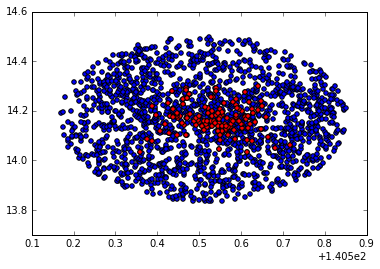

In [15]:
a_grp = big_grp

ax = pl.subplot(111)
pl.scatter(sdss_data[1,:],sdss_data[2,:],c='b')
pl.scatter(np.squeeze(groups[np.where(groups[:,4]==a_grp),1]),np.squeeze(groups[np.where(groups[:,4]==a_grp),2]),c='r')
pl.show()


…and let’s calculate the mean position of the cluster in all dimensions:

In [11]:
ra_cen = np.mean(groups[np.where(groups[:,4]==a_grp),1])
dec_cen = np.mean(groups[np.where(groups[:,4]==a_grp),2])
z_cen = np.mean(groups[np.where(groups[:,4]==a_grp),3])

print "Mean redshift: ",z_cen

Mean redshift:  0.142853984252
